In [47]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

import tensorflow as tf
import tensorflow.keras as K

import pickle
from zipfile import ZipFile, ZIP_DEFLATED

from skimage.color import rgb2gray, label2rgb
from lime import lime_image

In [2]:
fashion_mnist = K.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
class_names = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

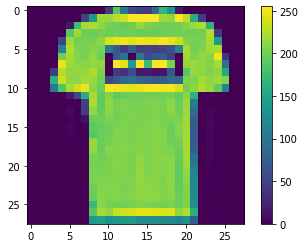

In [3]:
plt.figure()
plt.imshow(train_images[train_labels == 0][0])
plt.colorbar()
plt.grid(False)
plt.show()

In [4]:
reshape_2d = lambda X: X.reshape(X.shape[0], np.product(X.shape[1:]))

X_train = reshape_2d(train_images)
X_test = reshape_2d(test_images)

y_train = train_labels
y_test = test_labels

In [52]:
svc = make_pipeline(
    MinMaxScaler(),
    SVC(probability=True)
)

In [ ]:
%time svc.fit(X_train, y_train)

In [34]:
# with ZipFile('svc.zip', 'x', compression=ZIP_DEFLATED) as f:
#     f.writestr('svc.pickle', pickle.dumps(svc))
with ZipFile('svc.zip', 'r') as f:
    svc = pickle.loads(f.read('svc.pickle'))

In [30]:
%time accuracy_score(y_test, svc.predict(X_test))

CPU times: user 3min 47s, sys: 179 ms, total: 3min 47s
Wall time: 3min 49s


0.8829

In [46]:
mlp = make_pipeline(
    MinMaxScaler(),
    MLPClassifier(early_stopping=True, verbose=True)
)

In [47]:
%time mlp.fit(X_train, y_train)

Iteration 1, loss = 0.61131821
Validation score: 0.840333
Iteration 2, loss = 0.43244805
Validation score: 0.853000
Iteration 3, loss = 0.38934420
Validation score: 0.862000
Iteration 4, loss = 0.36608853
Validation score: 0.877167
Iteration 5, loss = 0.34732336
Validation score: 0.874500
Iteration 6, loss = 0.33114487
Validation score: 0.866833
Iteration 7, loss = 0.31832689
Validation score: 0.874167
Iteration 8, loss = 0.30508123
Validation score: 0.881000
Iteration 9, loss = 0.29798159
Validation score: 0.877000
Iteration 10, loss = 0.28690735
Validation score: 0.880333
Iteration 11, loss = 0.28101085
Validation score: 0.874667
Iteration 12, loss = 0.27427755
Validation score: 0.885333
Iteration 13, loss = 0.26739319
Validation score: 0.879167
Iteration 14, loss = 0.26245442
Validation score: 0.887167
Iteration 15, loss = 0.25408786
Validation score: 0.888500
Iteration 16, loss = 0.24653524
Validation score: 0.889500
Iteration 17, loss = 0.24632591
Validation score: 0.873833
Iterat

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('mlpclassifier',
                 MLPClassifier(early_stopping=True, verbose=True))])

In [5]:
# with ZipFile('mlp.zip', 'x', compression=ZIP_DEFLATED) as f:
#     f.writestr('mlp.pickle', pickle.dumps(mlp))
with ZipFile('mlp.zip', 'r') as f:
    mlp = pickle.loads(f.read('mlp.pickle'))

In [50]:
%time accuracy_score(y_test, mlp.predict(X_test))

CPU times: user 365 ms, sys: 76.3 ms, total: 441 ms
Wall time: 194 ms


0.8874

In [3]:
preprocess_X = lambda X: X / 255.0

X_train = preprocess_X(train_images)
X_test = preprocess_X(test_images)

y_train = K.utils.to_categorical(train_labels, len(class_names))
y_test = K.utils.to_categorical(test_labels, len(class_names))

In [4]:
max_p_class = lambda P: P.argmax(axis=-1)
!cat fmnist_resnet_model.h5* > fmnist_resnet_model.h5
resnet = K.models.load_model('fmnist_resnet_model.h5')
!rm fmnist_resnet_model.h5

In [54]:
%time accuracy_score(max_p_class(y_test), max_p_class(resnet.predict(X_test)))

CPU times: user 1min 28s, sys: 1.06 s, total: 1min 29s
Wall time: 29.6 s


0.9172

'Sandal'

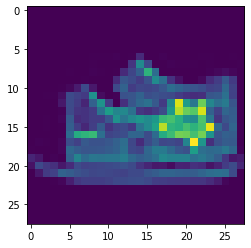

In [6]:
plt.imshow(X_test[-1].reshape(28, 28));
class_names[y_test[-1]]

In [39]:
def mlp_predict_proba(X):
    X = rgb2gray(X)
    X = X.reshape(*X.shape[:-2], np.product(X.shape[-2:]))
    return mlp.predict_proba(X)

In [81]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(X_test[-1].reshape(28, 28), mlp_predict_proba, labels=class_names.keys())

  0%|          | 0/1000 [00:00<?, ?it/s]

In [41]:
dir(explanation)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'get_image_and_mask',
 'image',
 'intercept',
 'local_exp',
 'local_pred',
 'score',
 'segments',
 'top_labels']

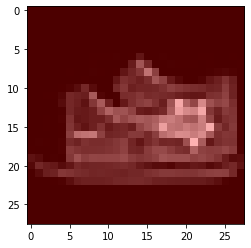

In [112]:
img, mask = explanation.get_image_and_mask(7, num_features=10)
plt.imshow(label2rgb(mask, img, bg_label=0))

In [173]:
y_pred_proba = mlp.predict_proba(X_test)
least_sure = np.amax(y_pred_proba, axis=-1).argmin()

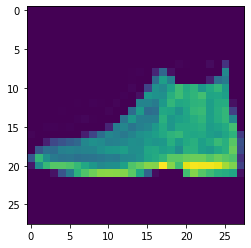

In [511]:
plt.imshow(X_test[0].reshape(28, 28))

<BarContainer object of 10 artists>

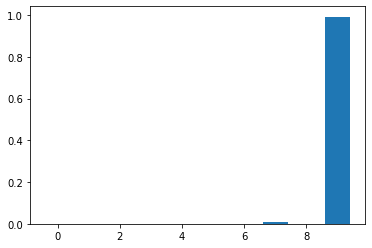

In [812]:
plt.bar(range(10), y_pred_proba[0])

In [513]:
class_names

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

In [849]:
from lime.wrappers.scikit_image import SegmentationAlgorithm
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=3, ratio=0.15)

In [850]:
explanation = explainer.explain_instance(X_test[0].reshape(28, 28), mlp_predict_proba, hide_color=0, top_labels=10, segmentation_fn=segmenter)

  0%|          | 0/1000 [00:00<?, ?it/s]

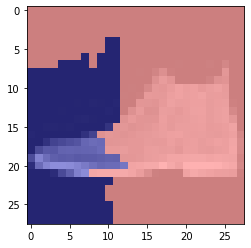

In [851]:
img, mask = explanation.get_image_and_mask(9, num_features=18, positive_only=False, negative_only=False)
plt.imshow(label2rgb(3-mask, img, bg_label=0))

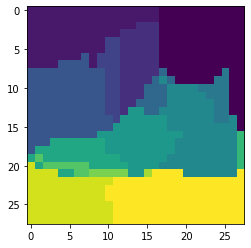

In [852]:
plt.imshow(explanation.segments)

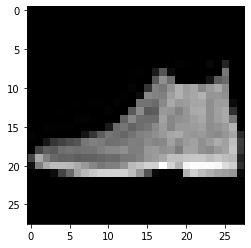

In [848]:
plt.imshow(explanation.image)